# Assignment 1 — Khashayar Vani - Gen AI - Discriminative vs. Generative Models (MNIST)

# Pre things that I did before starting my assignment


In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install scikit-learn 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:

import os
import math
import random
from pathlib import Path
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

Using device: cpu


## Dataset: MNIST
I use MNIST (28×28 grayscale handwritten digits).

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.26MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 959kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.95MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.70MB/s]
c:\Users\KhaShA\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


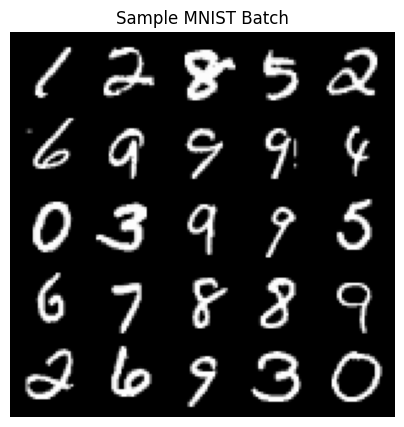

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # range ~[-1, 1]
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

def show_batch(dl, n=25):
    batch = next(iter(dl))[0][:n]
    grid = vutils.make_grid(batch, nrow=int(math.sqrt(n)), normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title('Sample MNIST Batch')
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.show()

show_batch(train_loader)

## Discriminative Model: Logistic Regression
I train a multinomial logistic regression classifier using scikit-learn. Input features are flattened pixels.

In [13]:
def to_numpy_dataset(dl):
    X_list, y_list = [], []
    for xb, yb in dl:
        # xb: (B,1,28,28) in [-1,1]; convert back to [0,1] for logistic regression stability
        xb = (xb + 1)/2.0
        X_list.append(xb.view(xb.size(0), -1).numpy())
        y_list.append(yb.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = to_numpy_dataset(train_loader)
X_test, y_test   = to_numpy_dataset(test_loader)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [14]:
logreg = LogisticRegression(
    penalty='l2', solver='saga', multi_class='multinomial', max_iter=200, n_jobs=-1, verbose=1
)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {acc:.4f}')
print(classification_report(y_test, y_pred))

c:\Users\KhaShA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 1946 seconds
Test Accuracy: 0.9256
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



c:\Users\KhaShA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


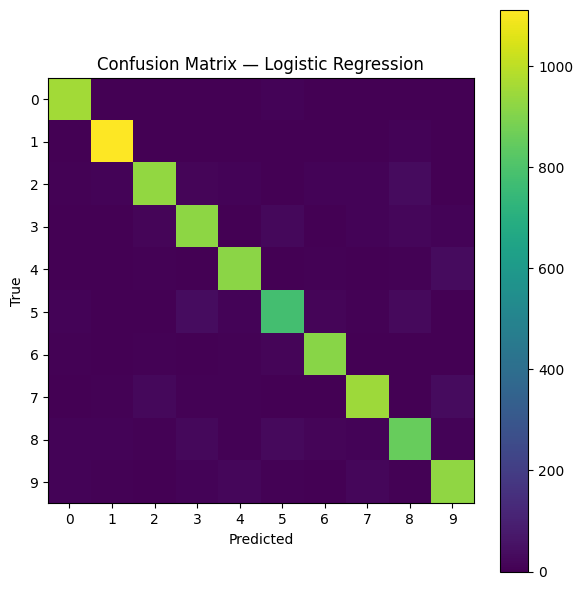

In [15]:
import itertools
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — Logistic Regression')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logreg_confusion_matrix.png', dpi=200)
plt.show()

## Generative Model: Simple GAN (MLP) on MNIST
To keep training light and fast, I implement an MLP-based GAN. For higher quality results, consider a Conv-DCGAN variant as an extension.

In [16]:
latent_dim = 64

class Generator(nn.Module):
    def __init__(self, zdim=latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(zdim, 256), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28), nn.Tanh()
        )
    def forward(self, z):
        x = self.net(z)
        return x.view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256), nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [17]:
def train_gan(epochs=10, sample_every=1):
    G_losses, D_losses = [], []
    fixed_z = torch.randn(64, latent_dim, device=device)
    for epoch in range(1, epochs+1):
        G_epoch_loss, D_epoch_loss = 0.0, 0.0
        for real, _ in train_loader:
            real = real.to(device)
            bs = real.size(0)

            # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
            z = torch.randn(bs, latent_dim, device=device)
            fake = G(z).detach()
            real_labels = torch.ones(bs, 1, device=device)
            fake_labels = torch.zeros(bs, 1, device=device)

            D_real = D(real)
            D_fake = D(fake)
            D_loss = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
            opt_D.zero_grad()
            D_loss.backward()
            opt_D.step()

            # Train Generator: minimize log(1 - D(G(z))) -> maximize log(D(G(z)))
            z = torch.randn(bs, latent_dim, device=device)
            fake = G(z)
            D_fake_for_G = D(fake)
            G_loss = criterion(D_fake_for_G, real_labels)
            opt_G.zero_grad()
            G_loss.backward()
            opt_G.step()

            G_epoch_loss += G_loss.item()
            D_epoch_loss += D_loss.item()

        G_losses.append(G_epoch_loss/len(train_loader))
        D_losses.append(D_epoch_loss/len(train_loader))

        print(f'Epoch {epoch}/{epochs} | G_loss: {G_losses[-1]:.4f} | D_loss: {D_losses[-1]:.4f}')
        if epoch % sample_every == 0:
            with torch.no_grad():
                samples = G(fixed_z).cpu()
            grid = vutils.make_grid(samples, nrow=8, normalize=True, value_range=(-1,1))
            plt.figure(figsize=(6,6))
            plt.axis('off')
            plt.title(f'GAN Samples — Epoch {epoch}')
            plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
            plt.show()
            vutils.save_image(samples, OUTPUT_DIR / f'gan_samples_epoch_{epoch:03d}.png', normalize=True, value_range=(-1,1))

    # Plot losses
    plt.figure(figsize=(6,4))
    plt.plot(G_losses, label='G_loss')
    plt.plot(D_losses, label='D_loss')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'gan_losses.png', dpi=200)
    plt.show()

    return G_losses, D_losses


c:\Users\KhaShA\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10 | G_loss: 1.0250 | D_loss: 1.1416
Epoch 2/10 | G_loss: 1.7590 | D_loss: 0.9429


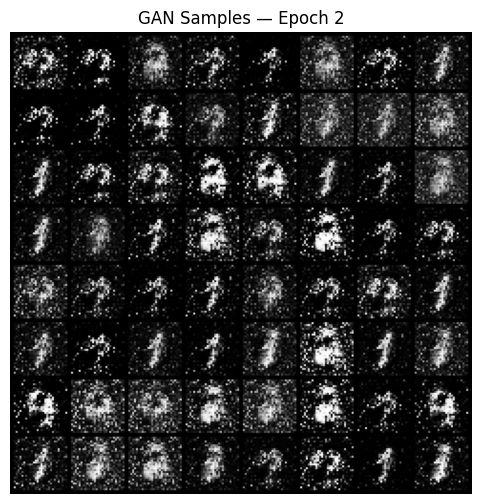

Epoch 3/10 | G_loss: 1.8997 | D_loss: 0.8849
Epoch 4/10 | G_loss: 1.9679 | D_loss: 0.8675


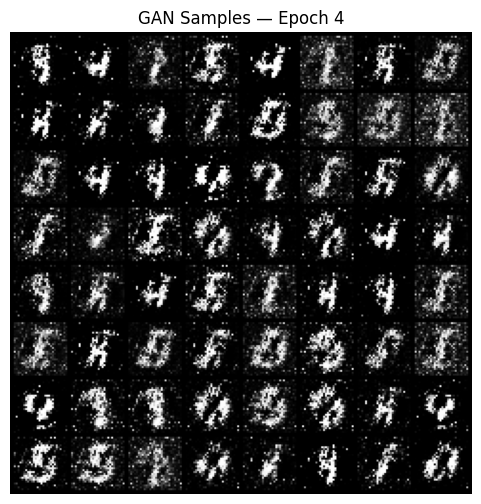

Epoch 5/10 | G_loss: 2.0952 | D_loss: 0.8100
Epoch 6/10 | G_loss: 2.1816 | D_loss: 0.8111


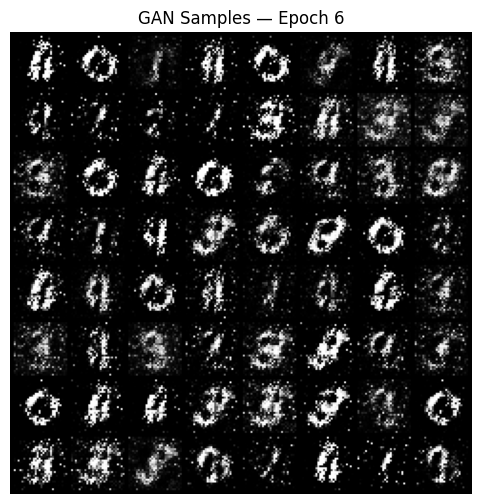

Epoch 7/10 | G_loss: 1.8586 | D_loss: 0.8478
Epoch 8/10 | G_loss: 1.8738 | D_loss: 0.8320


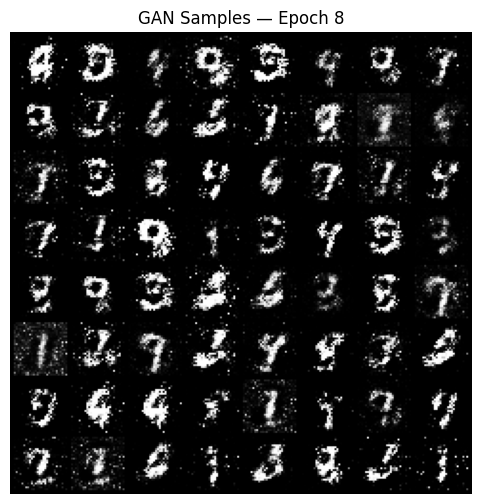

Epoch 9/10 | G_loss: 1.7031 | D_loss: 0.8726
Epoch 10/10 | G_loss: 1.5052 | D_loss: 0.9574


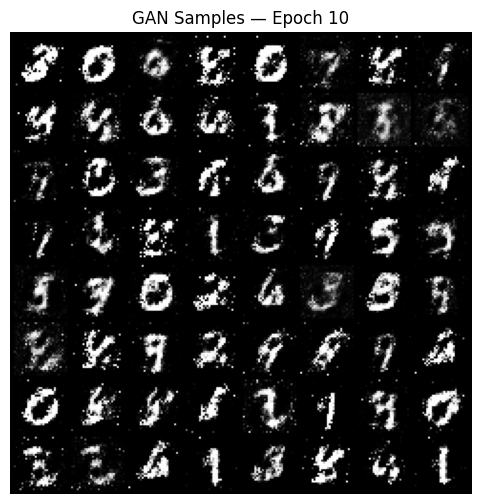

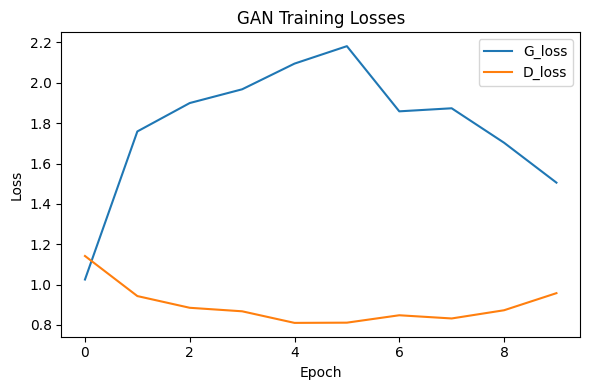

In [18]:
# ======== TRAINING RUNS ========
# NOTE: Adjust epochs upward (e.g., 30–50) for better samples if you have time/GPU.
G_losses, D_losses = train_gan(epochs=10, sample_every=2)


## Comparison & Reflection

### Core differences observed
- **Training stability:** Logistic regression converges smoothly with convex optimization; GAN training is non-convex and adversarial, often oscillatory.
- **Convergence speed:** Logistic regression typically reaches high accuracy rapidly; GAN requires many epochs and careful hyperparameters.
- **Evaluation:** Logistic regression → straightforward accuracy and confusion matrix; GAN → qualitative image quality/diversity + indirect metrics.

### Quantitative snapshot
- Logistic Regression Accuracy (Test): printed above
- GAN: see `outputs/gan_samples_epoch_*.png` and `outputs/gan_losses.png`

## GitHub Link
(https://github.com/Khashayarvani/MSIT3103-GenAI-assignments)

In [19]:
GITHUB_REPO_URL = "<paste-your-github-repo-url-here>"
print('GitHub repo:', GITHUB_REPO_URL)

GitHub repo: <paste-your-github-repo-url-here>
